# Description

evaluation based on:
- scaling with size of input
- scaling with data size
- scaling with number of runs

- no two hotels in the same place
- the fact that the coordinates reach around earth does not matter

## get dev data

In [1]:
import os
import sys
import shutil
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
sys.path.append("..")
from test_framework import comparison_test

In [3]:
datadir = '../data_sources/hotels_data'
if not os.path.exists(datadir):
    os.makedirs(datadir)


put as much as you need of this to datadir

https://www.dropbox.com/sh/2ebfiuzau02ns6y/AABNPprCbIiqoS2tcVFUfm14a?dl=0

## evaluate solutions on dev data

#### create testinputs

In [4]:
AGGED = pd.read_csv(datadir + '/agg.csv',index_col='index')

In [5]:
def generate_input(input_size):
    input_list = []
    for _ in range(input_size):
        input_dic = {c:np.random.uniform(AGGED.loc['min',c],AGGED.loc['max',c]) for c in AGGED.columns}
        input_dic['stars'] = np.linspace(0,5,11)[np.random.randint(11)]
        prices = np.sort( np.random.exponential(70,size=2))
        input_dic['min_price'] = prices[0]
        input_dic['max_price'] = prices[1]
        input_list.append(input_dic.copy())
    return input_list

In [6]:
envdir = 'env_dir'
stagedir = 'staging'

In [7]:
MINI_DATA = [3e3,6e3,12e3]
SMALL_DATA = [3e4,6e4,30e4,60e4]
BIG_DATA = [3e6,6e6,12e6,24e6,36e6,48e6,60e6]

use_datasets = SMALL_DATA
data_dicts = {int(data_size):{'datafile':datadir + '/hotels-%d.csv' % data_size,
'staging_folder':stagedir} for data_size in use_datasets}


input_sizes = [1,10,100]#,200,1000]
reps = 5

input_set = {}
for data_name in data_dicts.keys():
    input_set[data_name] = {}
    for input_size in input_sizes:
        input_set[data_name][input_size] = [generate_input(input_size) 
                                            for _ in range(reps)]

In [ ]:
WINDOWS = False #if false it assumes unix
timedata,out_dfs = comparison_test(data_dicts,input_set,
                                   envdir,stagedir,
                                   is_windows=WINDOWS,
                                  verbose=True)

base_solution


Starting ETL process
ETL process started
ETL process done
Starting cleanup process
cleanup process started
cleanup process done
ETL killed
Starting ETL process
ETL process started
ETL process done
Starting cleanup process
cleanup process started
cleanup process done
ETL killed
Starting ETL process
ETL process started
ETL process done
Starting cleanup process
cleanup process started
cleanup process done
ETL killed
Starting ETL process
ETL process started
ETL process done
Starting cleanup process
cleanup process started
cleanup process done
ETL killed
maybe_better_solution


Starting ETL process
ETL process started
ETL process done


In [17]:
similarity = []

for id1,solution1 in enumerate(list(out_dfs.keys())[:-1]):
    _df1 = out_dfs[solution1]
    solution2 = list(out_dfs.keys())[id1+1]
    _df2 = out_dfs[solution2]
    print('----------\n%s:\n' % solution1,_df1[_df1 != _df2].unstack().dropna())
    print('----------\n%s:\n' % solution2,_df2[_df1 != _df2].unstack().dropna())
    similarity.append({
        'solution1':solution1,
        'solution2':solution2,
        'similarity':(_df1 == _df2).mean().mean()
    })
pd.DataFrame(similarity).sort_values('similarity')

----------
base_solution:
 lat    476    57.9032
       46    -2.89591
       46    -6.76436
       59     44.4889
       141   -7.49976
       161     7.0705
       308    29.3619
       324   -6.76436
       487   -26.2024
       17     36.0897
       55     4.77304
       103    4.77304
       109    4.77304
       195    4.77304
       262    6.01901
       328    31.6171
       359    -3.7326
       396    4.77304
       490    36.0897
lon    2      90.3304
       116   -2.24667
       126   -1.76081
       476   -5.16431
       394    -4.7108
       482   -7.99229
       20      18.604
       90      2.6534
       342    127.153
price  52     220.393
       64     207.249
       274    28.0167
       439    220.393
       25     18.2735
       201    204.019
       20     43.7986
dtype: object
----------
little_better_solution:
 lat    476    57.9032
       46    -2.89591
       46    -6.76436
       59     44.4889
       141   -7.49976
       161     7.0705
       308    29.3619

,similarity,solution1,solution2
0,0.786186,base_solution,little_better_solution


In [18]:
timedf = pd.DataFrame(timedata).pivot_table(columns='solution',values='calc_time',
                                   index=['data_id','input_id'],aggfunc='median').reset_index()

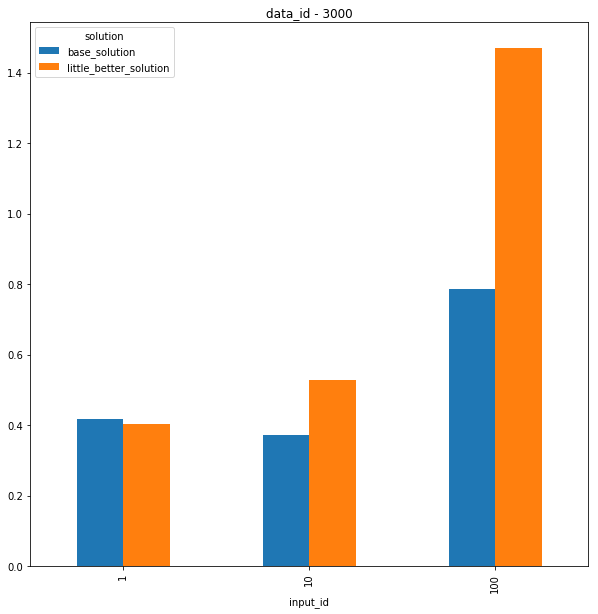

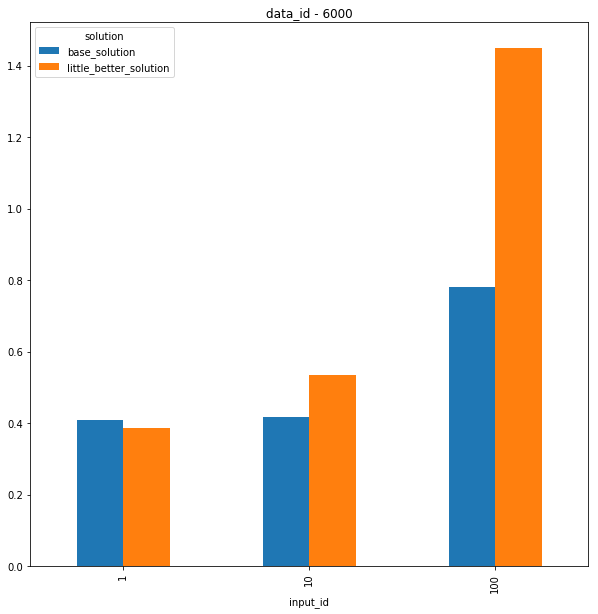

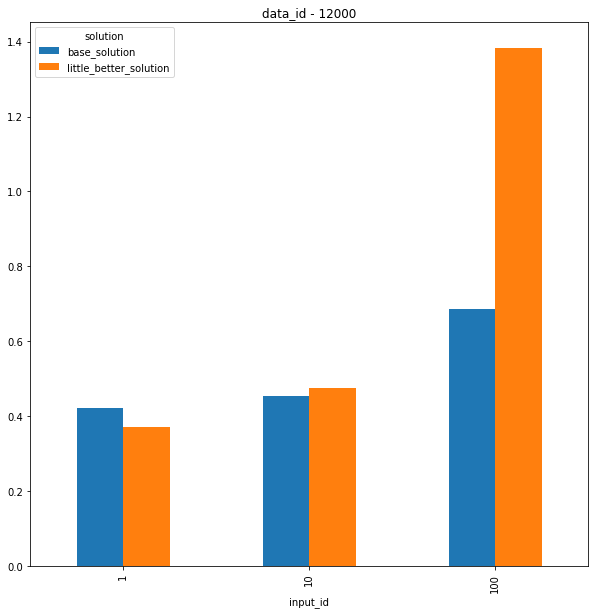

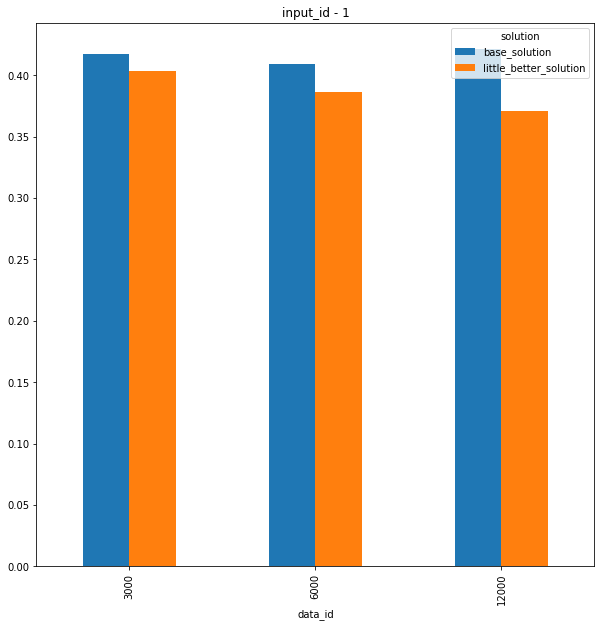

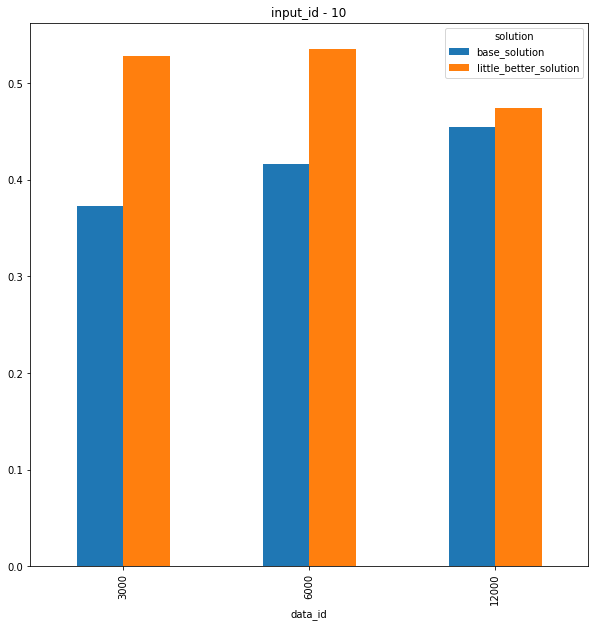

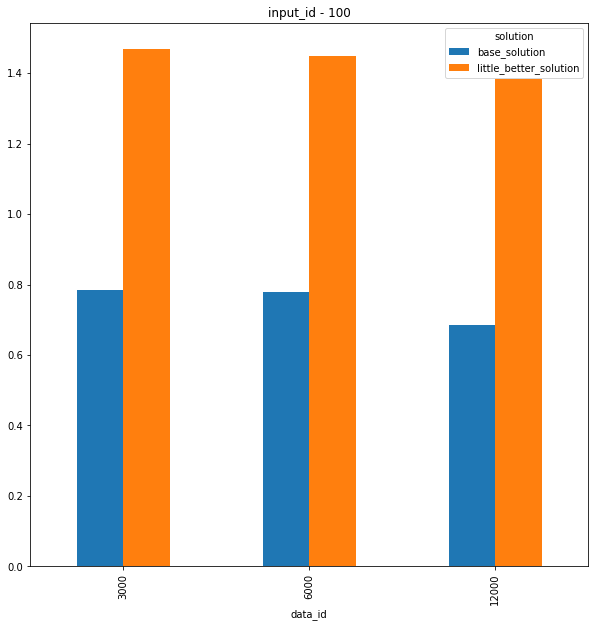

In [19]:
allgroups = ['data_id','input_id']
for basegroup in allgroups:
    remaingroup = [c for c in allgroups if c != basegroup]
    for _gname,_gdf in timedf.groupby(basegroup):
        _gdf.drop(basegroup,axis=1).groupby(remaingroup).median()\
        .plot(kind='bar',figsize=(10,10),title='%s - %s' % (str(basegroup),str(_gname)))